In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

def inverse(f, domain=(0.0, 1.0-1e-6), extrapolate=(float("NaN"), float("NaN"))):
    def inner(x):
        if f(domain[0]) >= x:
            return extrapolate[0]
        if f(domain[1]) <= x:
            return extrapolate[1]
        else:
            try:
                return scipy.optimize.brentq(lambda y: f(y)-x, a=domain[0], b=domain[1])
            except ValueError:
                return float("NaN")

    return np.vectorize(inner)

import scipy.misc
def derivative(f, dx=1e-6):
    return np.vectorize(lambda x: scipy.misc.derivative(f, x, dx))


# Spline interpolations

Piecewise linear functions (aka linear splines) had the advantage of being easy to fit and simple to work with. There disadvantage was that having a discontinuous first derivative (ie. they are $C^0$ functions), so that the the CDF derived from the Lorenz curve would be discontinuous, implying a discrete distribution (not a good match for income).

Ideally, we would like to fit the Lorenz curve with a $C^2$ function, a function that is twice continuously differentiable, so that the CDF (effectively a first derivative) would be smooth, and the PDF continuous (or perhaps even $C^3$, resulting in a smooth PDF).

One very common $C^2$ interpolant is cubic splines.

## Sample Lorenz curve data: India, 2011

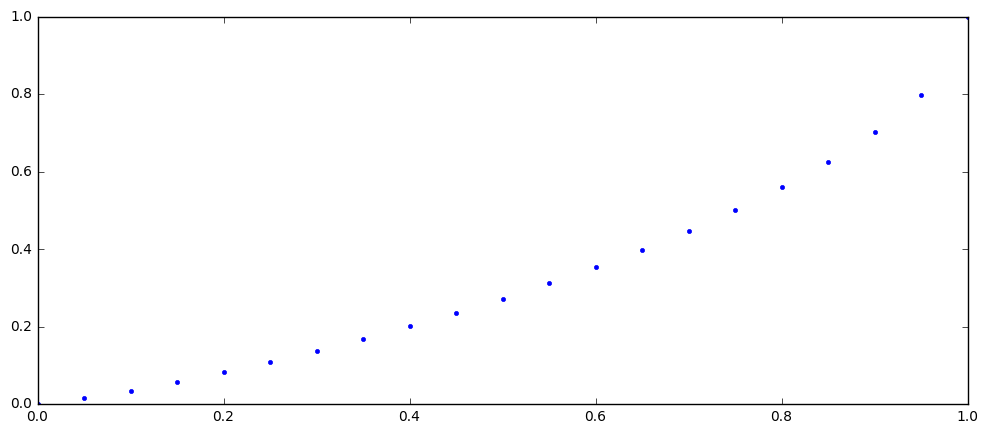

In [57]:
# Sample Lorenz curve coordinates for India 2011

ymean = 111.825
ymin = 37.195
ymax = 467947
N = 55184

p = [0.010006, 0.02004, 0.03001, 0.040037, 0.050035, 0.060061, 0.070101, 0.080022, 0.090016, 0.10001, 0.11016,
     0.12, 0.13003, 0.14019, 0.15006, 0.16003, 0.1701, 0.18003, 0.19, 0.20002, 0.21009, 0.22001, 0.23004, 0.24015,
     0.25009, 0.26001, 0.27, 0.2801, 0.29007, 0.30012, 0.31003, 0.32002, 0.33001, 0.34, 0.35003, 0.36001, 0.37001,
     0.38, 0.39006, 0.4, 0.4101, 0.42, 0.43007, 0.44002, 0.45004, 0.46, 0.47003, 0.48006, 0.49019, 0.50002, 0.51,
     0.52004, 0.53, 0.54, 0.55003, 0.56004, 0.57001, 0.58001, 0.59005, 0.60003, 0.61, 0.62003, 0.63001, 0.64003,
     0.65006, 0.66001, 0.67, 0.68003, 0.69001, 0.70001, 0.71, 0.72002, 0.73006, 0.74004, 0.75, 0.76009, 0.77001,
     0.78, 0.79001, 0.80001, 0.81001, 0.82006, 0.83001, 0.84004, 0.85006, 0.86009, 0.87, 0.88001, 0.89011, 0.9,
     0.91001, 0.92, 0.93002, 0.94, 0.95, 0.96, 0.97, 0.98005, 0.99001, 1]

L = [0.0023965, 0.0053924, 0.0086365, 0.012106, 0.015728, 0.019486, 0.02336, 0.027305, 0.031387, 0.035576, 0.03994, 
     0.044284, 0.048795, 0.053464, 0.058079, 0.062826, 0.067716, 0.072619, 0.077629, 0.082747, 0.08797, 0.093196,
     0.098557, 0.10405, 0.10953, 0.11509, 0.12075, 0.12656, 0.13238, 0.13832, 0.14425, 0.1503, 0.15643, 0.16263,
     0.16893, 0.17527, 0.1817, 0.1882, 0.19483, 0.20145, 0.20827, 0.21503, 0.222, 0.22899, 0.23612, 0.2433, 0.25062,
     0.25803, 0.26562, 0.27307, 0.28074, 0.28853, 0.29636, 0.30434, 0.31244, 0.32065, 0.32895, 0.33739, 0.34597,
     0.35461, 0.36336, 0.37227, 0.38129, 0.39048, 0.39981, 0.40921, 0.41879, 0.42858, 0.43847, 0.44855, 0.45879,
     0.46925, 0.47993, 0.49073, 0.50171, 0.51305, 0.52445, 0.53616, 0.54813, 0.56032, 0.5728, 0.58565, 0.59871,
     0.61222, 0.62611, 0.64041, 0.65498, 0.67022, 0.68614, 0.70235, 0.71951, 0.73749, 0.75642, 0.77638, 0.79784,
     0.82124, 0.84739, 0.87812, 0.91668, 1]

#p = [0.010084,0.020306,0.030188,0.040369,0.050147,0.060225,0.070195,0.080101,0.090115,0.10102,0.11049,0.12019,0.13058,0.14015,0.15006,0.16011,0.17043,0.18042,0.19048,0.20016,0.21003,0.22028,0.2301,0.24021,0.25016,0.26051,0.27007,0.28013,0.29045,0.30046,0.31033,0.32065,0.33014,0.34047,0.3501,0.36019,0.37005,0.38046,0.39019,0.40002,0.41001,0.42022,0.4303,0.4402,0.45015,0.46026,0.47006,0.48001,0.49003,0.50007,0.51016,0.52007,0.53015,0.54003,0.5501,0.56004,0.57009,0.58003,0.59002,0.60022,0.61013,0.62017,0.6302,0.6403,0.65038,0.66003,0.67024,0.68016,0.69015,0.70017,0.71031,0.7201,0.73004,0.74024,0.75007,0.76002,0.77009,0.7802,0.7901,0.80015,0.81021,0.82015,0.83031,0.84003,0.85026,0.86019,0.87019,0.88008,0.8901,0.90022,0.91002,0.92002,0.9301,0.94026,0.95017,0.96008,0.97015,0.9802,0.99028,1]
#L = [0.0002542,0.0029808,0.0062802,0.010027,0.013945,0.018229,0.022647,0.02721,0.032041,0.037477,0.042317,0.047427,0.053034,0.058292,0.063881,0.069639,0.075674,0.08163,0.087752,0.09375,0.09997,0.10654,0.11292,0.11958,0.12624,0.13326,0.13983,0.14683,0.15412,0.1613,0.16847,0.17607,0.18314,0.19093,0.19829,0.20609,0.21383,0.22208,0.22987,0.23784,0.24602,0.25447,0.26292,0.27128,0.27977,0.28846,0.29696,0.30569,0.31457,0.32353,0.33264,0.34165,0.3509,0.36007,0.36948,0.37887,0.38848,0.39807,0.40781,0.41786,0.4277,0.43777,0.44794,0.45826,0.46866,0.47873,0.48949,0.50007,0.51085,0.5218,0.53305,0.54401,0.55526,0.56696,0.5784,0.59018,0.60225,0.61451,0.62674,0.63938,0.65221,0.66509,0.6785,0.69158,0.7057,0.71975,0.73422,0.74882,0.76396,0.77963,0.79535,0.81181,0.82904,0.84701,0.86521,0.8844,0.90518,0.92761,0.95399,1]

# Add the minimum, maximum and origin point
p = [0.0] + p
L = [0.0] + L

# Down sample the Lorenz curve, for smoothness
pc = p[0:100:5] + [1.0]
Lc = L[0:100:5] + [1.0]
#pc = p[0:100:5]
#Lc = L[0:100:5]
#pc = [0.0] + [1.0/N] + pc + [] + [1.0]
#Lc = [0.0] + [(ymin-0.0) * (1.0/N - 0.0) / ymean] + Lc + [] + [1.0]

# Check that this is a valid convex function - if we're working from bad data we'll go astray
#assert np.all(np.diff(Lc) > 0)
#assert np.all(np.diff(np.diff(Lc)/np.diff(pc)) > 0)

plt.plot(pc, Lc, ".")

## Cubic spline interpolation of Lorenz curve

First we attempt a simple cubic spline interpolation of the Lorenz curve. The sharp turning points result because the cubic spline is not $C^3$. Another issue is that the space of polynmonial splines is not closed under inversion, so that the CDF is not a polynomial spline, and nor is the PDF. He we use numerical methods, but the result is that for fast visualization we will either rely on precomputation (resulting in a memory intensive grid of data points) or on-the-fly numerical methods (computationally intensive). One way to avoid this is to interpolate not points on the Lorenz curve, but points on the CDF itself. We'll come back to this.

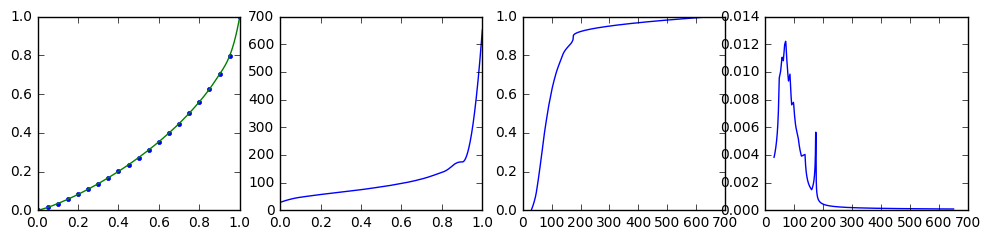

In [58]:
##########################################
plt.rcParams["figure.figsize"] = (12,2.5)
fig, ax = plt.subplots(1, 4)
##########################################

import scipy.interpolate

cubic_lorenz = scipy.interpolate.CubicSpline(pc, Lc, extrapolate=0)

x = np.linspace(0.0, 1.0, 1000)
y = np.linspace(0.0, 1000.0, 1000)
ax[0].plot(pc, Lc, ".")
ax[0].plot(x, cubic_lorenz(x))

cubic_quantile = lambda p: ymean * cubic_lorenz.derivative()(p)
ax[1].plot(x, cubic_quantile(x))

cubic_cdf = inverse(cubic_quantile)
ax[2].plot(y, cubic_cdf(y))

cubic_pdf = derivative(cubic_cdf)
ax[3].plot(y, cubic_pdf(y))

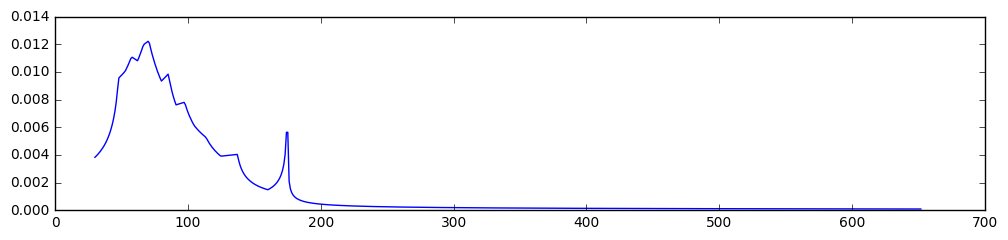

In [59]:
plt.plot(y, cubic_pdf(y))

## Direct cubic spline interpolation of CDF
Since our main objects in visualization are the CDF and PDF, we might try instead intepolating CDF points directly. Then, since the PDF is a simple first derivative, it will be easy to get from a $k$th degree polynomial spline representation of the CDF to a $(k-1)$th degree polynomial for the PDF.

As noted earlier, many Lorenz cuves (and hence CDFs) are consistent with a given sample of Lorenz curve points. Moreover, a given Lorenz curve point does not map unique to a CDF point. A Lorenz curve effectively defines a mean income for a sequence of quantile bands in the distribution. The mean value theorem suggests that some quantile within that band must have the mean income (assuming continuity), but we have no information of which quantile that will be.

Thus, we have to make an assumption. We choose to assign the mean income for each quantile band to the mid-point of that band. For a sequence of $N$ $(p, L)$ pairs sampled from the Lorenz curve, our procedure will give $N-1$ $(p, y)$ pairs sampled from a hypothetical CDF.

We also assume that the CDF starts at (0, 0) - that is no person has an income $<= 0$. (This may not be reasonable for a given data set.)

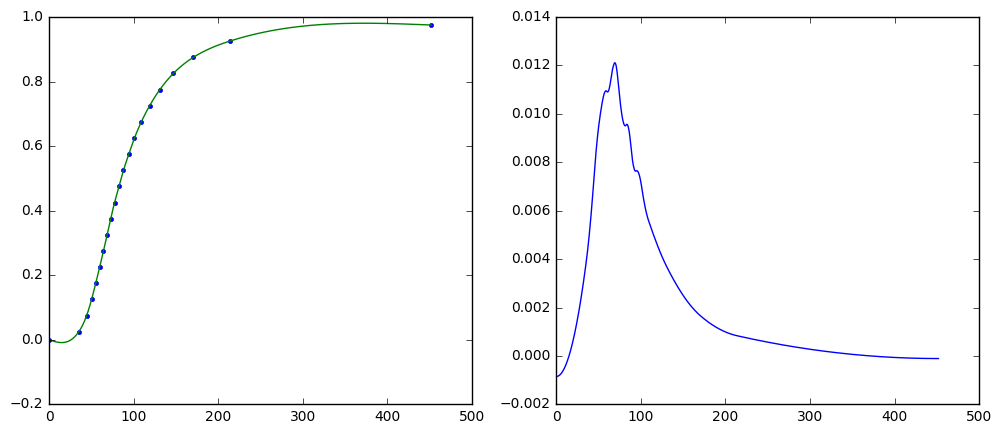

In [160]:
##########################################
plt.rcParams["figure.figsize"] = (12,5)
fig, ax = plt.subplots(1, 2)
##########################################

# The y values are simply the mean-scaled derivatives of the Lorenz curve
dL = np.diff(Lc)
dp = np.diff(pc)
y = ymean * dL/dp
y = np.hstack((0.0, y))

# And we arbitrarily assign these y values to the mid-points of the p values
pmid = np.add(pc[1:],pc[:-1])/2
pmid = np.hstack((0.0, pmid))

# Then calculate the direct interpolation of the CDF points
ccubic_cdf = scipy.interpolate.CubicSpline(y, pmid, bc_type=((2, 0.0), (2, 0.0)), extrapolate=0)
#ccubic_min = inverse(ccubic_cdf, (0, 500))(0.0)
ygrid = np.linspace(0, 500.0, 1000)

ax[0].plot(y, pmid, ".")
ax[0].plot(ygrid, ccubic_cdf(ygrid))

ccubic_pdf = derivative(ccubic_cdf)
ax[1].plot(ygrid, ccubic_pdf(ygrid))

## Direct PCHIP interpolation of CDF

An obvious issue with cubic splines - based on cubics - is that they are not constrained to be monotonic. We can see that above in the "CDF", which turns downward at both tails and is thus ill-formed. It's even more obvious in the "PDF", which is negative in the tails.

The PCHIP interpolator is a variant on cubic splines that does guarantee monotonicity. However, to do so, it sacrifices a continuous second derivative. This means that the PDF will not be smooth. It works, and is at least well-formed, but it's not very attractive.

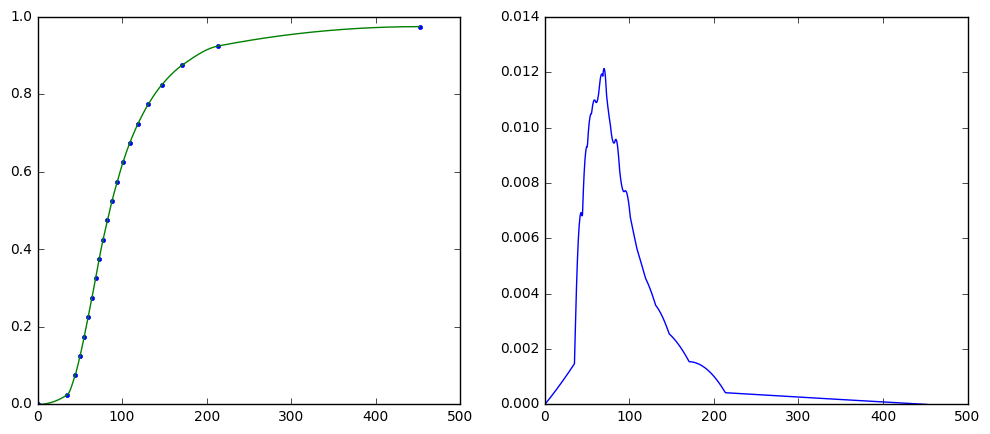

In [161]:
##########################################
plt.rcParams["figure.figsize"] = (12,5)
fig, ax = plt.subplots(1, 2)
##########################################

# Then calculate the direct interpolation of the CDF points
cpchip_cdf = scipy.interpolate.PchipInterpolator(y, pmid, extrapolate=0)

ax[0].plot(y, pmid, ".")
ax[0].plot(ygrid, cpchip_cdf(ygrid))

cpchip_pdf = derivative(cpchip_cdf)
ax[1].plot(ygrid, cpchip_pdf(ygrid))

## Cublic spline with pareto tails

Since the relatively flat tails seem to be the cause of most non-monotonicity with cubic spline interpolation, we can try instead to replace the tails with a Pareto tails, which naturally supports this asymptotic flattening. The advantage of retaining the cubic spline in the left and central parts of the distribution is that we can easily preserve some of the detail of distribution, rather than forcing it to fit a smooth parametric form.

The pareto distribution has two parameters, and we will impose two conditions, namely
1. That it pass through the final "observed" point of the CDF
2. That it match the derivative of the cubic spline at the second last point of the CDF

In addition we will vertically compress the pareto CDF so that it continues from the cubic spline.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local

-1.2113334235e-05 1.41333003478 0.683327213597 150.524352282
(0.9870141636751854, 6.746213020097737e-06)


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


TypeError: 'NoneType' object is not subscriptable

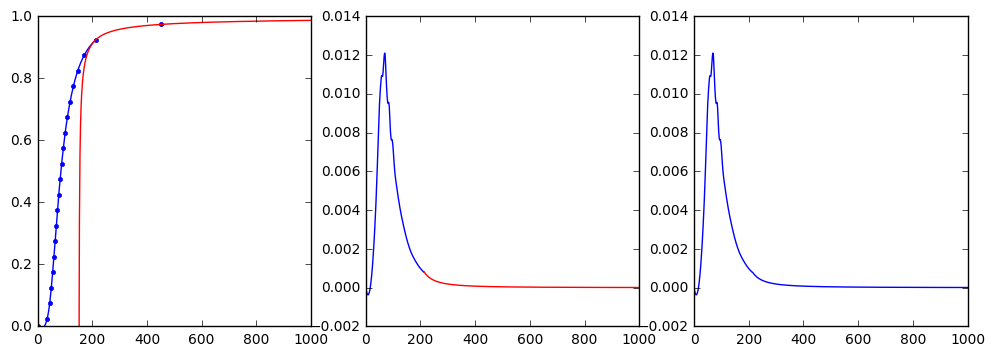

In [162]:
##########################################
plt.rcParams["figure.figsize"] = (12,4)
fig, ax = plt.subplots(1, 3)
##########################################

### F(x) = 1 - (x/xm)^a => solve for xm and a
#pmid = pmid[1:]
#y = y[1:]

p1 = pmid[-2]
y1 = y[-2]

p2 = pmid[-1]
y2 = y[-1]

#alpha = (np.log(1-p2) - np.log(1-p1)) / (np.log(y1) - np.log(y2))
#ym = np.exp(np.log(y2) + (1/alpha)*np.log(1-p2))
#yshift = 0

def pareto_cdf(y, ym, alpha, yshift):
    return 1 - (ym / (y - yshift))**alpha

def pareto_pdf(y, ym, alpha, yshift):
    return alpha * ym**alpha / (y - yshift)**(alpha+1)

def pareto_pdfderiv(y, ym, alpha, yshift):
    return -alpha*(alpha+1) * ym**alpha / (y - yshift)**(alpha+2)

def target(parameters):
    dd1, ym, alpha, yshift = parameters
    dd1 = dd1/100
    yshift = yshift*100

    ccubpar_cdf = scipy.interpolate.CubicSpline(y[:-1], pmid[:-1], bc_type=((1,0),(2,dd1)),extrapolate=0)
    ccubpar_pdf = ccubpar_cdf.derivative()

    err1 = pareto_cdf(y1, ym, alpha, yshift) - p1
    err1d = pareto_pdf(y1, ym, alpha, yshift) - ccubpar_pdf(y1)
    err1dd = pareto_pdfderiv(y1, ym, alpha, yshift) - ccubpar_pdf.derivative()(y1)
    #err1dd = 0
    err2 = pareto_cdf(y2, ym, alpha, yshift) - p2
    return err1**2 + (err1d*20)**2 + (err1dd*100)**2 + err2**2

from scipy.optimize import basinhopping
#guess = (-0.000015, 2.85446391657, 0.783499652638, 135.703869627)
guess = (-1, 1, 1, 1)
dd1, ym, alpha, yshift = basinhopping(target, guess).x
dd1 = dd1/100
yshift = yshift*100
print(dd1, ym, alpha, yshift)

ccubpar_cdf = scipy.interpolate.CubicSpline(y[:-1], pmid[:-1], bc_type=((1,0),(2,dd1)),extrapolate=0)
ccubpar_pdf = ccubpar_cdf.derivative()
d1 = ccubpar_pdf(y1)
dd1 = ccubpar_pdf.derivative()(y1)

xgrid = np.linspace(0.0, 1.0, 1000)
ygrid = np.linspace(0.0, 1000.0, 1000)

ax[0].plot(y, pmid, ".")
ax[0].plot(ygrid, ccubpar_cdf(ygrid), 'b-')
ax[1].plot(ygrid, ccubpar_pdf(ygrid), 'b-')

ax[0].plot(ygrid, pareto_cdf(ygrid, ym, alpha, yshift), 'r-')
ax[0].set_xlim((0,1000))
ax[0].set_ylim((0, 1.0))

ygrid2 = np.linspace(y1, 1000, 1000)

ax[1].plot(ygrid2, pareto_pdf(ygrid2, ym, alpha, yshift), 'r-')

final_pdf = np.vectorize(lambda z: 0.0 if z < y[0] else (ccubpar_pdf(z) if z < y1 else pareto_pdf(z, ym, alpha, yshift)))
ax[2].plot(ygrid, final_pdf(ygrid))
import scipy.integrate
print(scipy.integrate.quad(final_pdf, 0, 1e3))[0]

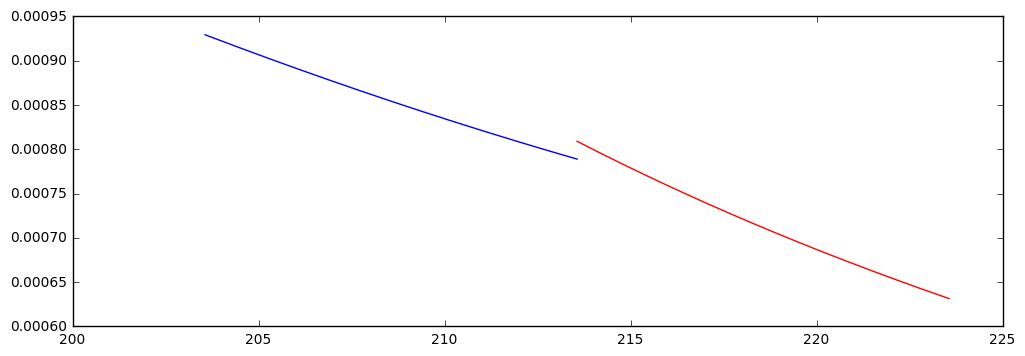

In [163]:
ygrid1 = np.linspace(y1-10, y1, 500)
ygrid2 = np.linspace(y1, y1+10, 500)
plt.plot(ygrid1, ccubpar_pdf(ygrid1), 'b-')
plt.plot(ygrid2, pareto_pdf(ygrid2, ym, alpha, yshift), 'r-')



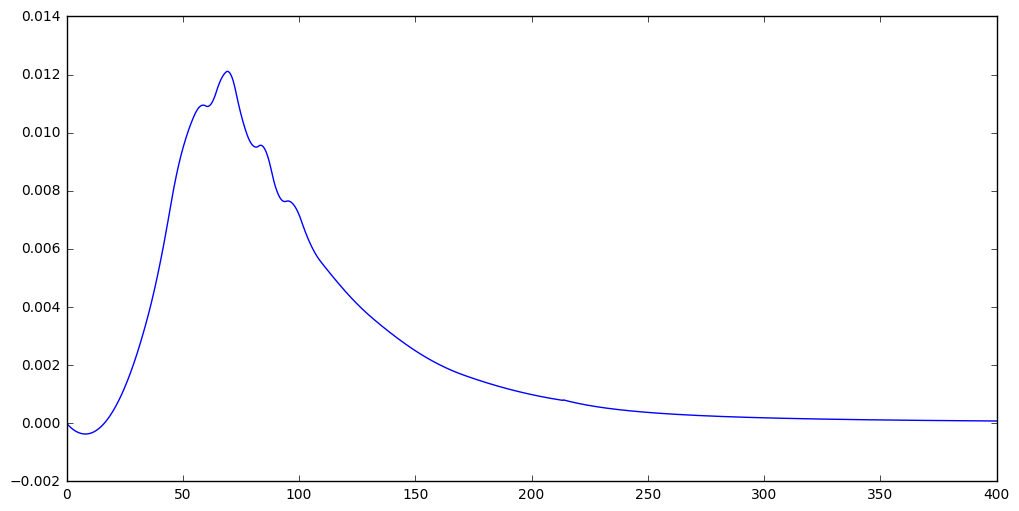

In [164]:
##########################################
plt.rcParams["figure.figsize"] = (12,6)
##########################################

ygrid = np.linspace(0, 400, 2000)
plt.plot(ygrid, final_pdf(ygrid), 'b-')


In [165]:
from scipy.integrate import quad

final_cdf = lambda y: quad(final_pdf, 0, y)[0]
final_quantile = inverse(final_cdf, domain=(0, 1e6))
final_mean = quad(lambda y: y * final_pdf(y), 0, 1e6)[0]
final_lorenz = np.vectorize(lambda p: quad(lambda y: y * final_pdf(y), 0, final_quantile(p))[0] / ymean)
final_lorenz(0.5) # should be 0.27

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


array(0.2731389087911804)

In [166]:
final_L = final_lorenz(np.asarray(pc[1:-1]))
final_L = np.hstack((0.0, final_L, 1.0))

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


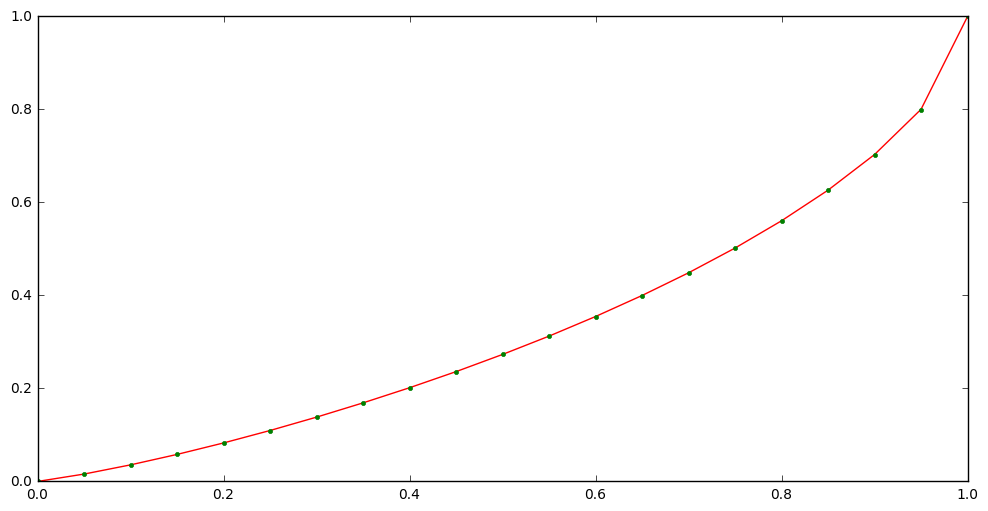

In [167]:
plt.plot(pc, final_L,'r-')
plt.plot(pc, Lc,'g.')